In [1]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from data.load_dataset import load_dataset
from data.merge_dataset import merge_dataset
from data.feature_engineering import *
from model.inference import save_csv
from model.feature_select import select_features
from model.data_split import split_features_and_target
from model.model_train import *
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import os
import wandb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
match torch.cuda.is_available():
    case True: device = "cuda"
    case _: device = "cpu"

device

'cuda'

In [4]:
train_data, test_data, sample_submission, interest_data, subway_data, school_data, park_data = load_dataset()
# 기존 데이터에 새로운 feature들을 병합한 데이터프레임 불러오기
train_data, test_data = merge_dataset(train_data, test_data, interest_data, subway_data, school_data, park_data)

### 3. Data Preprocessing

# 위치 중복도 낮은 행 삭제
groups = train_data.groupby(["latitude", "longitude"])["index"].count()
conditioned_groups_index = groups[(groups >= 2) & (groups <= 5)].index # 이 범위를 파라미터로 조정하는걸로
small_groups = train_data[
    train_data["latitude"].isin(conditioned_groups_index.get_level_values(0)) &
    train_data["longitude"].isin(conditioned_groups_index.get_level_values(1))
]
train_data.drop(small_groups.index, axis=0, inplace=True)

# built_year > 2024 행 삭제
train_data = train_data[train_data["built_year"] < 2024]
train_data.reset_index(drop=True, inplace=True)

# log 변환
train_data, test_data = apply_log_transformation(train_data, test_data)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [5]:
selected_cols = [
    "log_area_m2",
    "built_year",
    "latitude",
    "longitude",
    "log_leader_distance",
    "log_subway_distance",
    "log_school_distance",
    "log_park_distance",
    "contract_year_month",
    # "contract_day",
    "num_of_subways_within_radius",
    "park",
    "region"
]
X_train, y_train = train_data[selected_cols], train_data["deposit"]
X_test = test_data[selected_cols]
log_y_train = train_data["log_deposit"]

# 1. 데이터 불러오기
X_train, X_valid, y_train, y_valid = train_test_split(X_train, log_y_train, test_size=0.2)

X_train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
X_val = torch.tensor(X_valid.values, dtype=torch.float32, device=device)
y_val = torch.tensor(y_valid.values, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=device)

# 데이터로더 설정
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [6]:
# 2. 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(12, 36)
        self.fc2 = nn.Linear(36, 18)
        self.fc3 = nn.Linear(18, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = torch.log1p(self.fc3(out))
        return out

In [7]:
# 5. 모델 학습

# 3. 모델 인스턴스 생성
model = SimpleModel()
model.to(device)

# 가중치 초기화
for layer in model.children():
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)

# 4. 손실 함수와 옵티마이저 정의
criterion = nn.L1Loss()  # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam 옵티마이저
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# 학습 과정
num_epochs = 1000
loss_df = []
for epoch in range(num_epochs): # tqdm(range(num_epochs), desc="💃Total Epoch🕺"):
    model.train()
    epoch_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"✨Epoch {epoch+1}✨:", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    scheduler.step(average_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_loss}')
    loss_df.append(average_loss)

# 검증 과정
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(torch.expm1(outputs), torch.expm1(targets))
        val_loss = loss.item()

print(f'Validation Loss: {val_loss}')

Epoch [10/1000], Train Loss: 0.43572156360198605


Epoch [20/1000], Train Loss: 0.4011503777088242


Epoch [30/1000], Train Loss: 0.3755121230679571


Epoch [40/1000], Train Loss: 0.3703079747124496


Epoch [50/1000], Train Loss: 0.3657814025644515


Epoch [60/1000], Train Loss: 0.36191534253971136


Epoch [70/1000], Train Loss: 0.360459638444697


Epoch [80/1000], Train Loss: 0.3597078834523762


Epoch [90/1000], Train Loss: 0.35554598964233375


Epoch [100/1000], Train Loss: 0.33557163323550837


Epoch [110/1000], Train Loss: 0.3355392551324101


Epoch [120/1000], Train Loss: 0.3324174398255205


Epoch [130/1000], Train Loss: 0.3320227519259695


Epoch [140/1000], Train Loss: 0.3319699801954084


Epoch [150/1000], Train Loss: 0.3319735631742238


Epoch [160/1000], Train Loss: 0.3319763417207307


Epoch [170/1000], Train Loss: 0.3319701326070261


Epoch [180/1000], Train Loss: 0.33197075385320324


Epoch [190/1000], Train Loss: 0.33197811613486466


Epoch [200/1000], Train Loss: 0.33197052213342126


Epoch [210/1000], Train Loss: 0.3319760577503313


Epoch [220/1000], Train Loss: 0.3319756600708475


Epoch [230/1000], Train Loss: 0.33197370545907146


Epoch [240/1000], Train Loss: 0.33197449554556635


Epoch [250/1000], Train Loss: 0.33197372410250303


Epoch [260/1000], Train Loss: 0.33197214780362877


Epoch [270/1000], Train Loss: 0.33197358118506515


Epoch [280/1000], Train Loss: 0.3319744123659501


Epoch [290/1000], Train Loss: 0.3319747729263737


Epoch [300/1000], Train Loss: 0.33197113814308343


Epoch [310/1000], Train Loss: 0.3319687671125047


Epoch [320/1000], Train Loss: 0.33197282993694405


Epoch [330/1000], Train Loss: 0.3319721336988653


Epoch [340/1000], Train Loss: 0.3319774401583166


Epoch [350/1000], Train Loss: 0.33196617803541434


Epoch [360/1000], Train Loss: 0.33197767393834493


Epoch [370/1000], Train Loss: 0.33197567648622983


Epoch [380/1000], Train Loss: 0.33197254031584955


Epoch [390/1000], Train Loss: 0.3319770750166083


Epoch [400/1000], Train Loss: 0.3319707866626596


Epoch [410/1000], Train Loss: 0.33197246127403907


Epoch [420/1000], Train Loss: 0.33197422810241783


Epoch [430/1000], Train Loss: 0.331972623315677


Epoch [440/1000], Train Loss: 0.3319674648423757


Epoch [450/1000], Train Loss: 0.33197007763294145


Epoch [460/1000], Train Loss: 0.33197759201325494


Epoch [470/1000], Train Loss: 0.3319690429830862


Epoch [480/1000], Train Loss: 0.3319698823250505


Epoch [490/1000], Train Loss: 0.33196881446754


Epoch [500/1000], Train Loss: 0.3319695149166717


Epoch [510/1000], Train Loss: 0.3319706038081387


Epoch [520/1000], Train Loss: 0.3319751879055343


Epoch [530/1000], Train Loss: 0.33197021811191063


Epoch [540/1000], Train Loss: 0.3319718114481033


Epoch [550/1000], Train Loss: 0.33197247192286244


Epoch [560/1000], Train Loss: 0.33197174077379615


Epoch [570/1000], Train Loss: 0.33196954774210924


Epoch [580/1000], Train Loss: 0.33197275204445


Epoch [590/1000], Train Loss: 0.33197339787507935


Epoch [600/1000], Train Loss: 0.33197493252155236


Epoch [610/1000], Train Loss: 0.33197013964941957


Epoch [620/1000], Train Loss: 0.3319685928665374


Epoch [630/1000], Train Loss: 0.33197177109417664


Epoch [640/1000], Train Loss: 0.3319721369230776


Epoch [650/1000], Train Loss: 0.33197409162008684


Epoch [660/1000], Train Loss: 0.3319695398087625


Epoch [670/1000], Train Loss: 0.3319789179422568


Epoch [680/1000], Train Loss: 0.3319722682900846


Epoch [690/1000], Train Loss: 0.3319698040982824


Epoch [700/1000], Train Loss: 0.33197300632972265


Epoch [710/1000], Train Loss: 0.3319756918987903


Epoch [720/1000], Train Loss: 0.3319716194176953


Epoch [730/1000], Train Loss: 0.3319710477492756


Epoch [740/1000], Train Loss: 0.331977133095046


Epoch [750/1000], Train Loss: 0.33198029002637025


Epoch [760/1000], Train Loss: 0.3319739165777218


Epoch [770/1000], Train Loss: 0.3319731902896117


Epoch [780/1000], Train Loss: 0.3319767629085975


Epoch [790/1000], Train Loss: 0.33197530738650466


Epoch [800/1000], Train Loss: 0.3319745806669015


Epoch [810/1000], Train Loss: 0.33197625804036945


Epoch [820/1000], Train Loss: 0.3319704549456849


Epoch [830/1000], Train Loss: 0.3319696792409614


Epoch [840/1000], Train Loss: 0.3319835242375749


Epoch [850/1000], Train Loss: 0.33197598186880817


Epoch [860/1000], Train Loss: 0.3319674412887126


Epoch [870/1000], Train Loss: 0.331972403773589


Epoch [880/1000], Train Loss: 0.3319746927006207


Epoch [890/1000], Train Loss: 0.3319687004628029


Epoch [900/1000], Train Loss: 0.3319734934348184


Epoch [910/1000], Train Loss: 0.33197302843708487


Epoch [920/1000], Train Loss: 0.3319706041424127


Epoch [930/1000], Train Loss: 0.3319737209941546


Epoch [940/1000], Train Loss: 0.33197518788955305


Epoch [950/1000], Train Loss: 0.33197188743217265


Epoch [960/1000], Train Loss: 0.3319715579365883


Epoch [970/1000], Train Loss: 0.33197122086057584


Epoch [980/1000], Train Loss: 0.3319742780197763


Epoch [990/1000], Train Loss: 0.33196999818094614


Epoch [1000/1000], Train Loss: 0.3319710139449879
Validation Loss: 9255.01953125


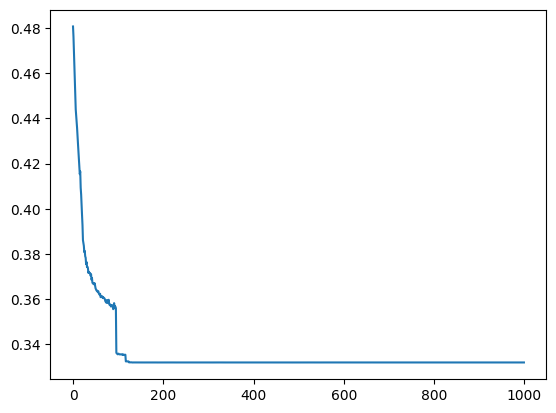

In [8]:
plt.plot(loss_df)

In [9]:
# 6. 예측 수행 및 배치 단위로 MAE 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
print(y_pred)

tensor([10.0727,  9.3057,  9.3057,  ..., 10.8713, 10.7248, 10.7284],
       device='cuda:0')


<Axes: ylabel='Count'>

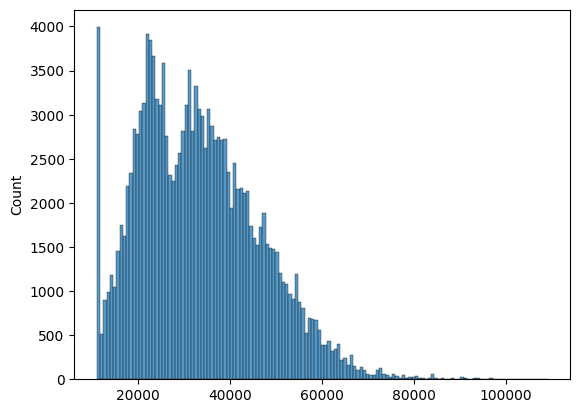

In [10]:
import seaborn as sns
y_pred = y_pred.cpu()
y_pred = pd.Series(torch.expm1(y_pred))
sns.histplot(y_pred)

In [11]:
sample_submission["deposit"] = y_pred
sample_submission.to_csv("output.csv", index=False)

In [12]:
y_pred.describe()

count    150172.000000
mean      33269.847656
std       13030.113281
min       10999.956055
25%       22989.978516
50%       31992.305664
75%       41813.495117
max      109067.921875
dtype: float64